<a href="https://colab.research.google.com/github/MaslovAleksey/Direct-and-convolutional-neural-networks-for-audio-signal-processing/blob/main/Direct_and_convolutional_neural_networks_for_audio_signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Определение цифр на основании аудиозаписи**

## **1.) Техническое описание**

* ### **Постановка задачи:**
> #### На основании аудиозаписей, содержащих произношение цифр различными людьми, необходимо обучить нейронноу сеть для определения произнесённой цифры.

---

* ### **Используемые библиотеки:**
> #### keras, sklearn, numpy, matplotlib, librosa, random, warnings, os, ffmpeg, base64.

---

* ### **Анализируемые параметры аудиозаписи:**
> #### 1.   Среднеквадратичная амплитуда (*rms(x)*)
> #### 2.   Средняя частота смены знака сигнала (*zero_crossing_rate(x)*)
> #### 3.   Среднее значение спектрального центроида (*spectral_rolloff(x, sr)*)
> #### 4.   Среднее значение спектрального спада частоты 85% (*spectral_rolloff(x, sr))*)
> #### 5.   Среднее значение ширины полосы частот (*spectral_bandwidth(x, sr)*)
> #### 6.   Мел-частотные кепстральные коэффициенты сигнала (*mfcc(x, sr)*)
> #### 7.   Частоты цветности сигнала (*chroma_stft(x, sr, hop_length=hop_length)*)

---

* ### **Особенности реализации алгоритма:**
> #### 1.   Слои, формирующие архитектуру нейронной сети: *Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input, concatenate*;
> #### 2.   Нейронная сеть имеет три входа, каждый, из которых отвечает за анализ отдельного длока данных. В 2-х из 3-х  ветвях нейронной сети используются свёрточные нейронные сети;
> #### 3.   Каждый свёрточный блок состоит из *BatchNormalization, Conv2D, Conv2D, MaxPooling2D, Dropout*;
> #### 4.   В качестве праметра *loss* при обучении модели была выбрана функция *sparse_categorical_crossentropy*, позволяющая не преобразовывать набор данных *y_data* к формату *OHE*;
> #### 5.   При формировании наборов данных приведение векторов *mfcc* и *chroma* к одной длине осуществлялось при помощи функции *pad_sequences(...)* добавлением нулей в конец последовательности. 

## **2.) Загрузка данных**

### **Подключение необходимых библиотек**

In [44]:
import os # инструменты для работы с файлами и папкам
import sklearn
import numpy as np
import random
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.keras.models import Model # инструменты для функционального API
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Input, concatenate # необходимые слои
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences # приведение данных к одному размеру
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from google.colab.output import eval_js
from google.colab import drive
from base64 import b64decode # модуль для кодировки/раскодировки аудиозаписи(64-разрядный код)
from scipy.io.wavfile import read as wav_read # для чтения WAV формата
import io
import scipy

import librosa # параметризация аудио
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings("ignore") # отключение вывода предупреждений на экран

In [73]:
!pip install ffmpeg-python
import ffmpeg # кроссплатформенная open-source библиотека для обработки видео- и аудиофайлов

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/UAI/8.) Neural networks for audio processing/Data/recordings.zip'

### **Анализ имеющихся данных**

In [5]:
records = os.listdir('/content/recordings')
n = len(records)
print(f"\033[1mКоличество записей для анализа\033[0m - {n}")

Количество записей для анализа - 3000


In [60]:
# Анализ случайной записи
rand_record = random.choice(records)
path = '/content/recordings/' + rand_record
x, sr = librosa.load(path)
numb, name, att = rand_record.replace(".wav", "").split("_")
time = len(x)/sr
print(f"\033[1m{name} произносит цифру {numb} (попытка {att})\033[0m")
print(f"\033[1mДлина записи\033[0m - {time} с")
ipd.Audio(path)

jackson произносит цифру 8 (попытка 3)
Длина записи - 0.3896598639455782 с


In [66]:
print(min(x))

-0.4949579


In [7]:
# Функция нормализации
def normalize(data, axis = 0):
  return sklearn.preprocessing.minmax_scale(data, axis=axis)

График амплитуды сигнала


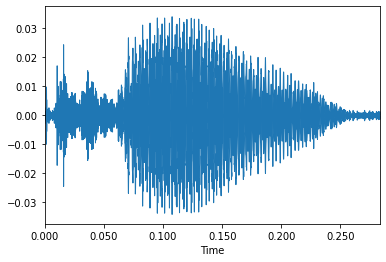

In [8]:
print("\033[1mГрафик амплитуды сигнала\033[0m")
librosa.display.waveplot(x, sr=sr)
plt.show()

Спектрограмма сигнала


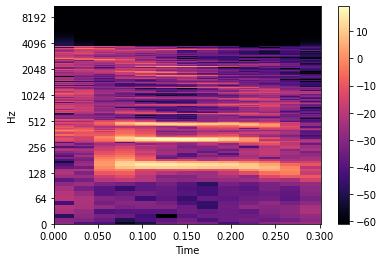

In [9]:
ampl = librosa.stft(x)
x_db = librosa.amplitude_to_db(abs(ampl))
print("\033[1mСпектрограмма сигнала\033[0m")
librosa.display.specshow(x_db, sr = sr, x_axis = "time", y_axis = 'log')
plt.colorbar()
plt.show()

Спектральный центроид сигнала


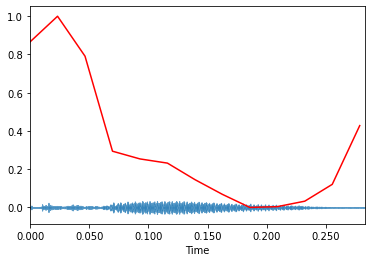

In [10]:
print("\033[1mСпектральный центроид сигнала\033[0m")
spec_centr = librosa.feature.spectral_centroid(x, sr)[0]
librosa.display.waveplot(x, sr=sr, alpha = 0.7)

# Вспомогательные параметры
frames = range(len(spec_centr)) # выичсление количества блоков
t = librosa.frames_to_time(frames)

plt.plot(t, normalize(spec_centr), color = 'r')
plt.show()

Спектральный спад частоты сигнала


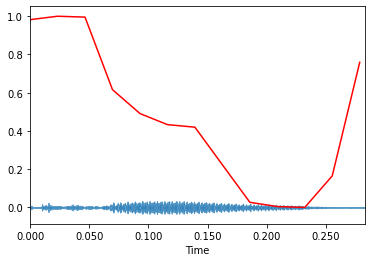

In [11]:
print("\033[1mСпектральный спад частоты сигнала\033[0m")
rolloff = librosa.feature.spectral_rolloff(x, sr, roll_percent = 0.85)[0]
librosa.display.waveplot(x, sr=sr, alpha = 0.7)

plt.plot(t, normalize(rolloff), color = 'r')
plt.show()

Мел-частотные кепстральные коэффициенты сигнала
MFCC shape - (20, 13)


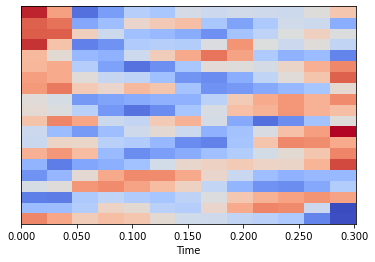

In [12]:
print("\033[1mМел-частотные кепстральные коэффициенты сигнала\033[0m")
mfcc = librosa.feature.mfcc(x, sr)
print(f"\033[1mMFCC shape\033[0m - {mfcc.shape}")
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

librosa.display.specshow(mfcc, sr = sr, x_axis = "time")
plt.show()

Частоты цветности сигнала


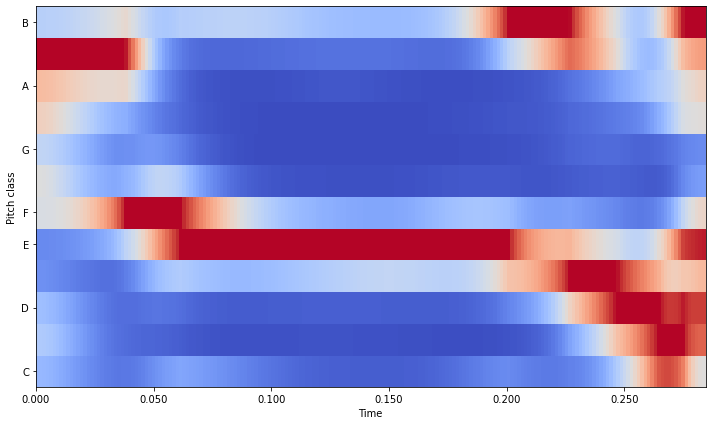

In [13]:
print("\033[1mЧастоты цветности сигнала\033[0m")

hop_length = 32
chromagram = librosa.feature.chroma_stft(x, sr, hop_length=hop_length)
#print(chromagram.shape)

plt.figure(figsize=(12,7))
librosa.display.specshow(chromagram, x_axis = "time", y_axis="chroma", hop_length=hop_length, cmap = 'coolwarm')
plt.show()

## **3.) Функции для реализации процесса обучение нейронной сети**

### **Вычисление основных параметров аудиозаписи**

In [19]:
def get_features(x, sr):
  
  base = []

  rms = np.mean(librosa.feature.rms(x)) # среднеквадратичная амплитуда
  zcr = np.mean(librosa.feature.zero_crossing_rate(x)) # средняя частота смены знака сигнала
  spec_cent = np.mean(librosa.feature.spectral_centroid(x, sr)) # среднее значение спектрального центроида
  rolloff = np.mean(librosa.feature.spectral_rolloff(x, sr)) # среднее значение спектрального спада частоты (85%)
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(x, sr)) # среднее значение ширины полосы частот

  param = [rms, zcr, spec_cent, rolloff, spec_bw]

  for p in param:
    base.append(p)

  mfcc = librosa.feature.mfcc(x, sr) # мел-частотные кепстральные коэффициенты сигнала

  hop_length = 32
  chroma = librosa.feature.chroma_stft(x, sr, hop_length=hop_length)

  return base, mfcc, chroma

### **Формирование выборки данных**

In [84]:
def create_set(records):
  x_data_base = [] # средние значения основных параметров
  x_data_mfccs = [] # мел-частотные кепстральные коэффициенты
  x_data_chroma = [] # частоты цветности
  y_data = []
  max_mfcc = 0 # максимальная длина выборки mfcc
  max_chroma = 0 # максимальная длина выборки chroma
  k = len(records)

  for r in records:
    curr_numb = int(r.split('_')[0]) # получаем цифру, произносимую в текущей записи
    y_data.append(curr_numb)

    path = '/content/recordings/' + r # путь к текущей записи
    x, sr = librosa.load(path) # амплитуда и частота дискретизации

    curr_base, curr_mfccs, curr_chroma = get_features(x, sr) # получаем наборы данных

    x_data_base.append(curr_base)
    x_data_mfccs.append(curr_mfccs)
    x_data_chroma.append(curr_chroma)

    if (curr_mfccs.shape[1] > max_mfcc):
      max_mfcc = curr_mfccs.shape[1]

    if (curr_chroma.shape[1] > max_chroma):
      max_chroma = curr_chroma.shape[1]

  # Приведение каждой строки np.array из x_data_mfccs, x_data_chroma к длине max_mfcc, max_chroma
  for i in range(k):
    x_data_mfccs[i] = pad_sequences(x_data_mfccs[i], max_mfcc, padding='post')
    x_data_chroma[i] = pad_sequences(x_data_chroma[i], max_chroma, padding='post')


  x_data_base = np.array(x_data_base)
  x_data_mfccs = np.array(x_data_mfccs)
  x_data_chroma = np.array(x_data_chroma)
  y_data = np.array(y_data)

  return x_data_base, x_data_mfccs, x_data_chroma, y_data

### **Формирование архитектуры нейронной сети**

In [21]:
'''
  1.) Архитектура нейронной сети имеет три входа 
для обработки следующих параметров:
- усреднённые базовые характеристики аудиосигнала (пооносвязные слои) 
- мел-частотные кепстральные коэффициенты (свёрточные блоки)
- частоты цветности (свёрточные блоки)

  2.) Функция активации - "softmax", позволяющая получить вероятности принадлежности
анализируемой записи к той или иной цифре
'''

def create_model(base_len, mfcc_shape, chroma_shape, y_len, dropout_rate):
  # Базовые характеристики
  input_base = Input((base_len, ), name='base')

  base = Dense(256, activation='relu')(input_base)
  base = Dense(512, activation='relu')(base)

  # Мел-частотные кепстральные коэффициенты
  input_mfcc = Input(shape = mfcc_shape, name = 'mfcc')

  mfcc = BatchNormalization()(input_mfcc)
  mfcc = Conv2D(32, (3,3), padding='same', activation="relu")(mfcc)
  mfcc = Conv2D(32, (3,3), padding='same', activation="relu")(mfcc)
  mfcc = MaxPooling2D(2,3)(mfcc) # (10,33,32)
  mfcc = Dropout(dropout_rate)(mfcc)

  mfcc = Flatten()(mfcc)
  mfcc = Dropout(dropout_rate)(mfcc)
  mfcc = Dense(512, activation="relu")(mfcc)


  # Частоты цветности
  input_chroma = Input(shape = chroma_shape, name = 'chroma')

  chroma = BatchNormalization()(input_chroma)
  chroma = Conv2D(32, (3,3), padding='same', activation="relu")(chroma)
  chroma = Conv2D(32, (3,3), padding='same', activation="relu")(chroma)
  chroma = MaxPooling2D(2,15)(chroma) # (6,105,32)  
  chroma = Dropout(dropout_rate)(chroma)

  chroma = Flatten()(chroma)
  chroma = Dropout(dropout_rate)(chroma)
  chroma = Dense(512, activation="relu")(chroma)

  # Совмещение всех входов модели
  merge = layers.concatenate([base, mfcc,chroma])


  output = Dense(units = y_len, activation = "softmax")(merge)


  model = Model(inputs = [input_base, input_mfcc, input_chroma], outputs = output)

  return model

### **Построение графиков ошибки и точности обучения**

In [22]:
def plot_graphs(history):
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,16))

  fig.suptitle("Характеристики обучения", size = 25, y = 1)

  ax[0].plot(history.history["loss"], label = "тренировочные данные")
  ax[0].plot(history.history["val_loss"], label = "проверочные данные данные")
  ax[0].set_title("Функция ошибки модели при обучении", size = 17, pad = 21)
  ax[0].set_xlabel("Число эпох", size = 12)
  ax[0].set_ylabel("Ошибка обучения", size = 12)
  ax[0].legend(prop = {"size":12})

  ax[1].plot(history.history["accuracy"], label = "тренировочные данные")
  ax[1].plot(history.history["val_accuracy"], label = "проверочные данные данные")
  ax[1].set_title("Точность модели при обучении", size = 17, pad = 21)
  ax[1].set_xlabel("Число эпох", size = 12)
  ax[1].set_ylabel("Показатель точночти", size = 12)
  ax[1].legend(prop = {"size":12})

  plt.show()

### **Проверка сети на тестовой выборке**

In [27]:
def check_model(model, test_data, real_data, use_model=None):

  if (use_model == "Да"):
    path_model = input("Путь к предобученной модели - ")
    model = models.load_model(filepath = path_model)

  pred = model.predict(test_data)
  pred = np.argmax(pred, axis=1) # Формирование массива предсказанных данных
  k = len(real_data) # Число записей для предсказания

  test_acc = np.round(sum(pred==real_data)/k * 100, 2)

  return test_acc

### **Запись с микрофона**

In [45]:
def get_audio(AUDIO_HTML): # объявляем функцию извлечения аудио, записанного через микрофон в ноутбуке
  display(ipd.HTML(AUDIO_HTML)) # c помощью модулей библиотеки IPython отображаем результат выполнения записанного выше скрипта AUDIO_HTML
  data = eval_js("data") # данные на выходе запишем в data как результат выполнения javascript кода
  # data сейчас в таком виде: 'data:audio/webm;codecs=opus;base64,GkXfo59ChoEBQveBAULygQRC84EIQoKEd2VibUKHgQRChYE...mpZpkq1'
  binary = b64decode(data.split(',')[1]) #отсекаем информацию "data:audio/webm;codecs=opus;base64", оставляем только данные и декодируем
  # b'\x1aE\xdf\xa3\x9fB\x86\x81\x01B\xf7\x81\x01B\xf2

  process = (ffmpeg
    .input('pipe:0') # поток стандартного ввода
    .output('pipe:1', format='wav') # стандартного вывода в формате wav 
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)) # асинхронное выполнение командной строки FFmpeg
  # binary преобразовываем в wav, с типичным для медиафайлов форматом RIFF(ResourceInterchangeFileFormat - формат файла для обмена ресурсами)
  output, err = process.communicate(input=binary)
  # output - b'RIFF\xff\xff\xff\xffWAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80\xbb\x00\x00\...\x01\x00\x01\x00\x01\x0\xff'
  # err - b"ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers\n...headers:0kB muxing overhead: 0.046695%\n"


  # Cодержимое файла группируется из отдельных секций (chunks) - формат выборок аудиоданных. Секция имеет свой заголовок и данные секции.
  # Размер заголовка секции RIFF - 8 байт, их ниже уберём из определения размера секции RIFF
  riff_chunk_size = len(output) - 8 
  # Разбиваем размер секции на четыре байта, которые запишем далее в b.
  q = riff_chunk_size
  b = [] 
  for i in range(4):
    q, r = divmod(q, 256) # возьмем размер секции и вернем частное и остаток от деления на 256, и так 4 раза 
    b.append(r) # каждый из остатков добавим в список

  # Меняем байты c 4го по 7й вкл-но('\xff\xff\xff\xff') в output на b (типа '\xc62\x02\x00')
  riff = output[:4] + bytes(b) + output[8:]

  # класс io.BytesIO позволит работать с последовательностью байтов как с файловым объектом, а далее прочитаем как wav файл
  sr, audio = wav_read(io.BytesIO(riff)) # извлечём частоту дискретизации и полученный сигнал

  return audio, sr # функция вернет полученный сигнал и частоту дискретизации

### **Воспроизведение аудио записи**

In [47]:
def play_audio(audio, sr):
  print("\033[1mЗапись с микрофона:\033[0m")
  ipd.display(ipd.Audio(audio, rate=sr, autoplay=True))

### **Распознавание цифры по аудио записи**

In [87]:
def recognition_number(model, AUDIO_HTML, max_chroma, max_mfcc):

  audio, sr = get_audio(AUDIO_HTML) # запись с микрофона
  scipy.io.wavfile.write('my_recording.wav', sr, audio) # сохранение в формате .wav
  path = "/content/my_recording.wav"
  x, sr = librosa.load(path, sr=sr)


  base, mfccs, chroma = get_features(x, sr) # извлечение набора данных

  # Приведение данных к необходимому виду
  mfccs = pad_sequences(mfccs, max_mfcc, padding='post', truncating='pre')
  mfccs = np.expand_dims(mfccs, axis=0)

  chroma = pad_sequences(chroma, max_chroma, padding='post', truncating='pre')
  chroma = np.expand_dims(chroma, axis=0)

  base = np.expand_dims(base, axis=0)

  data = [base, mfccs, chroma] # набор данных для подачи в сеть

  pred = model.predict(data)
  pred_number = np.squeeze(np.argmax(pred, axis=-1)) # предсказанная цифра

  print(f"\033[1mВы произнесли цифру - {pred_number}\033[0m")

## **4.) Формирование и обучение нейронной сети**

### **Создание набора данных**

In [81]:
x_base, x_mfcc, x_chroma, y_data = create_set(records)

In [82]:
print(f"Размер x_base - {x_base.shape}")
print(f"Размер x_mfcc - {x_mfcc.shape}")
print(f"Размер x_chroma - {x_chroma.shape}")
print(f"Размер y_data - {y_data.shape}")

Размер x_base - (3000, 5)
Размер x_mfcc - (3000, 20, 99)
Размер x_chroma - (3000, 12, 1573)
Размер y_data - (3000,)


In [26]:
x_base_train_val, x_base_test, x_mfcc_train_val, x_mfcc_test, x_chroma_train_val, x_chroma_test, y_train_val, y_test = train_test_split(x_base, x_mfcc, x_chroma, y_data, test_size = 0.1, shuffle = True) 
x_base_train, x_base_val, x_mfcc_train, x_mfcc_val, x_chroma_train, x_chroma_val, y_train, y_val = train_test_split(x_base_train_val, x_mfcc_train_val, x_chroma_train_val, y_train_val, test_size = 0.2, shuffle = True) 

print(f"Размер x_base_train - {x_base_train.shape}")
print(f"Размер x_base_val - {x_base_val.shape}")
print(f"Размер x_base_test - {x_base_test.shape}")

print(f"Размер x_mfcc_train - {x_mfcc_train.shape}")
print(f"Размер x_mfcc_val - {x_mfcc_val.shape}")
print(f"Размер x_mfcc_test - {x_mfcc_test.shape}")

print(f"Размер x_chroma_train - {x_chroma_train.shape}")
print(f"Размер x_chroma_val - {x_chroma_val.shape}")
print(f"Размер x_chroma_test - {x_chroma_test.shape}")

print(f"Размер y_train - {y_train.shape}")
print(f"Размер y_val - {y_val.shape}")
print(f"Размер y_test - {y_test.shape}")

Размер x_base_train - (2160, 5)
Размер x_base_val - (540, 5)
Размер x_base_test - (300, 5)
Размер x_mfcc_train - (2160, 20, 99)
Размер x_mfcc_val - (540, 20, 99)
Размер x_mfcc_test - (300, 20, 99)
Размер x_chroma_train - (2160, 12, 1573)
Размер x_chroma_val - (540, 12, 1573)
Размер x_chroma_test - (300, 12, 1573)
Размер y_train - (2160,)
Размер y_val - (540,)
Размер y_test - (300,)


### **Архитектура нейронной сети**

In [31]:
base_len = len(x_base[0]) # длина вектора, содержащего усредннёные значения основных характеристик
y_len = 10 # длина вектора на выходе модели
mfcc_shape = np.expand_dims(x_mfcc[0], axis=-1).shape # размерность mfcc вектора
chroma_shape = np.expand_dims(x_chroma[0], axis=-1).shape # размерность chroma вектора
dropout_rate = float(input("Коэффициент отключения нейронов при обучении (dropout_rate) - "))

Коэффициент отключения нейронов при обучении (dropout_rate) - 0.3


In [32]:
model = create_model(base_len, mfcc_shape, chroma_shape, y_len, dropout_rate)

In [44]:
print("\033[1mСтруктура модели\033[0m\n")
model.summary()

Структура модели

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 99, 1)]  0           []                               
                                                                                                  
 chroma (InputLayer)            [(None, 12, 1573, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 99, 1)   4           ['mfcc[0][0]']                   
 alization)                                                                                       
                                                                            

Визуализация архитектуры



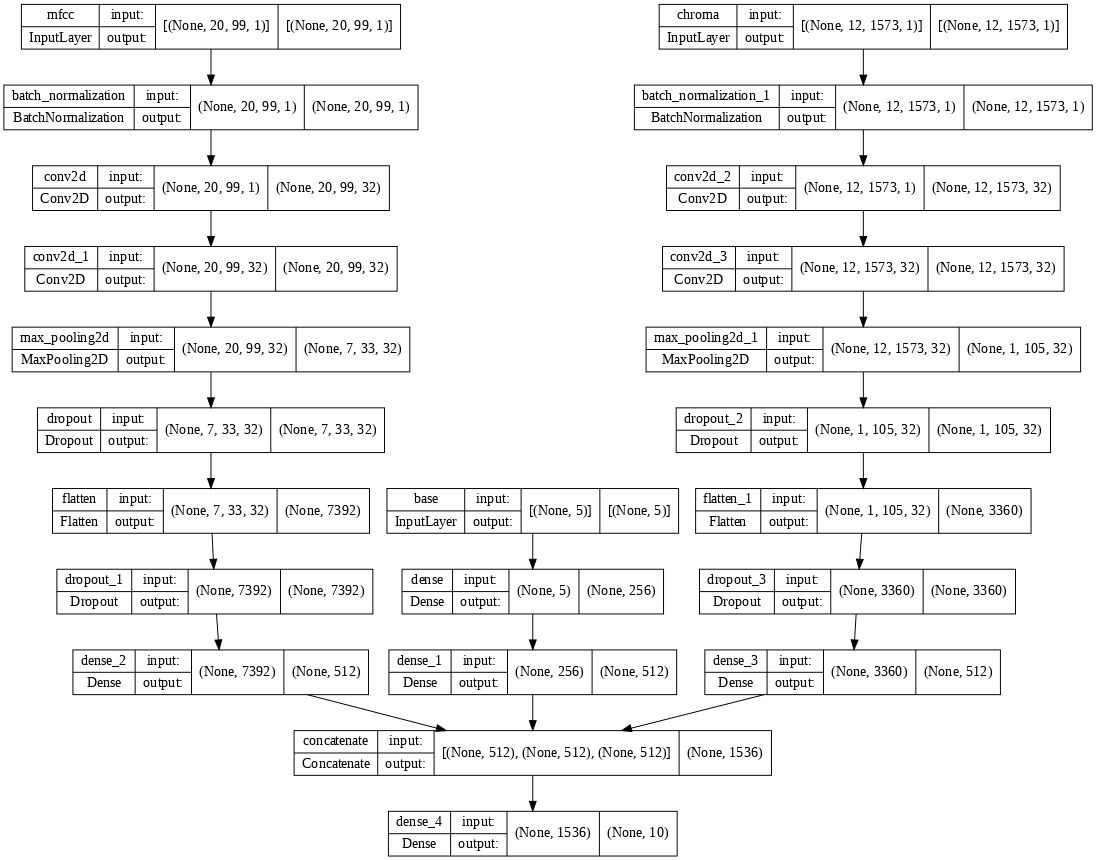

In [45]:
print("\033[1mВизуализация архитектуры\033[0m\n")
plot_model(model, dpi=70, show_shapes=True)

### **Первый этап обучений**

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=1e-5),
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy']
)

hist = model.fit(
    {'base':x_base_train, 'mfcc':x_mfcc_train, 'chroma':x_chroma_train},
    y_train,
    epochs = 45,
    batch_size = 32,
    validation_data = ({'base':x_base_val, 'mfcc':x_mfcc_val, 'chroma':x_chroma_val}, y_val),
    verbose = 1)

Epoch 1/45
68/68 [==============================] - 100s 1s/step - loss: 78.1696 - accuracy: 0.1495 - val_loss: 42.8525 - val_accuracy: 0.0926
Epoch 2/45
68/68 [==============================] - 99s 1s/step - loss: 24.0401 - accuracy: 0.1093 - val_loss: 10.7701 - val_accuracy: 0.1130
Epoch 3/45
68/68 [==============================] - 99s 1s/step - loss: 5.3482 - accuracy: 0.1319 - val_loss: 3.5210 - val_accuracy: 0.1519
Epoch 4/45
68/68 [==============================] - 99s 1s/step - loss: 3.1948 - accuracy: 0.1736 - val_loss: 2.7306 - val_accuracy: 0.2093
Epoch 5/45
68/68 [==============================] - 99s 1s/step - loss: 2.6403 - accuracy: 0.2199 - val_loss: 2.3951 - val_accuracy: 0.2407
Epoch 6/45
68/68 [==============================] - 99s 1s/step - loss: 2.3083 - accuracy: 0.2569 - val_loss: 2.0705 - val_accuracy: 0.2574
Epoch 7/45
68/68 [==============================] - 99s 1s/step - loss: 2.1563 - accuracy: 0.2662 - val_loss: 1.9701 - val_accuracy: 0.3093
Epoch 8/45
68/6

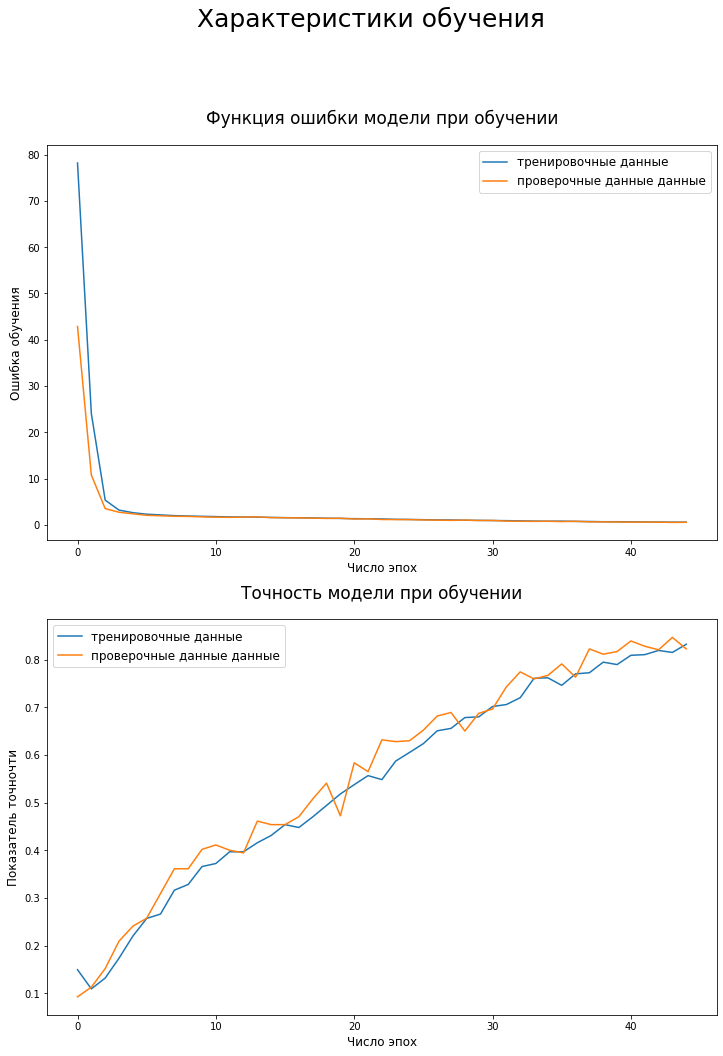

In [ ]:
plot_graphs(hist)

In [ ]:
model.save("learn_45_epochs.h5") # Сохранение модели для дальнейшего обучения

### **Второй этап обучений**

In [ ]:
model = models.load_model("/content/drive/MyDrive/Colab Notebooks/UAI/8.) Neural networks for audio processing/Neural networks/learn_45_epochs.h5")

In [ ]:
hist = model.fit(
    {'base':x_base_train, 'mfcc':x_mfcc_train, 'chroma':x_chroma_train},
    y_train,
    epochs = 30,
    batch_size = 32,
    validation_data = ({'base':x_base_val, 'mfcc':x_mfcc_val, 'chroma':x_chroma_val}, y_val),
    verbose = 1)

Epoch 1/30
68/68 [==============================] - 101s 1s/step - loss: 0.5759 - accuracy: 0.8245 - val_loss: 0.5564 - val_accuracy: 0.8185
Epoch 2/30
68/68 [==============================] - 100s 1s/step - loss: 0.5596 - accuracy: 0.8319 - val_loss: 0.5270 - val_accuracy: 0.8574
Epoch 3/30
68/68 [==============================] - 99s 1s/step - loss: 0.5632 - accuracy: 0.8315 - val_loss: 0.4789 - val_accuracy: 0.8648
Epoch 4/30
68/68 [==============================] - 102s 2s/step - loss: 0.5504 - accuracy: 0.8287 - val_loss: 0.4781 - val_accuracy: 0.8722
Epoch 5/30
68/68 [==============================] - 101s 1s/step - loss: 0.5185 - accuracy: 0.8468 - val_loss: 0.4445 - val_accuracy: 0.8722
Epoch 6/30
68/68 [==============================] - 101s 1s/step - loss: 0.4926 - accuracy: 0.8509 - val_loss: 0.4742 - val_accuracy: 0.8537
Epoch 7/30
68/68 [==============================] - 101s 1s/step - loss: 0.4839 - accuracy: 0.8588 - val_loss: 0.5049 - val_accuracy: 0.8500
Epoch 8/30
68/

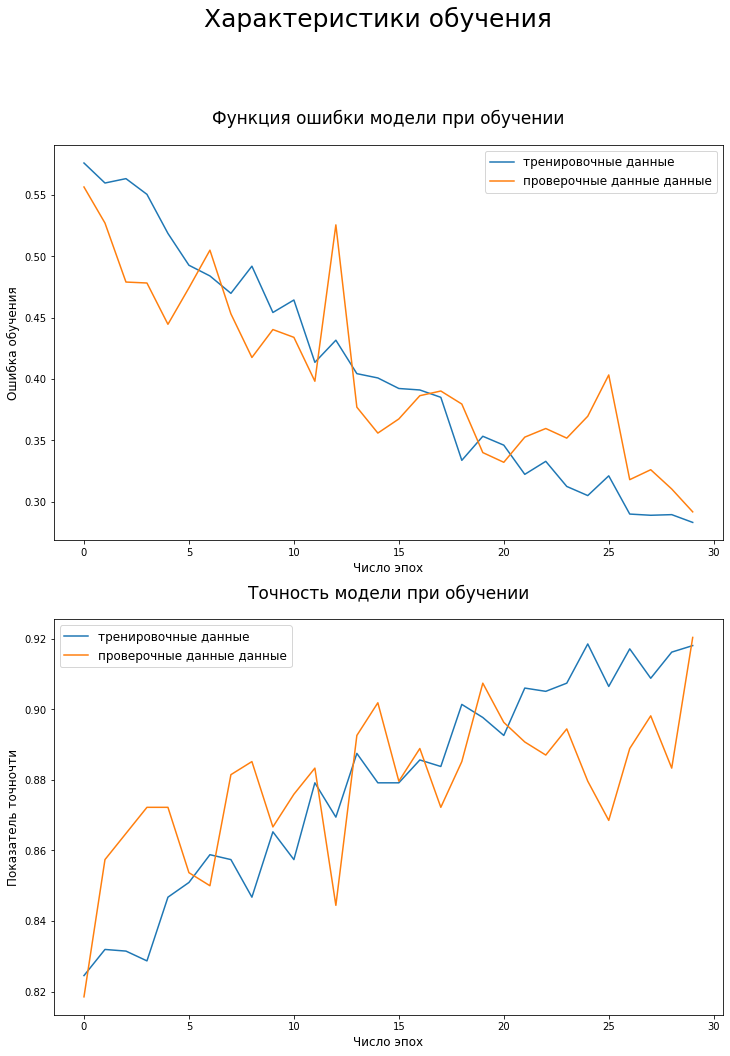

In [ ]:
plot_graphs(hist)

### **Третий этап обучения**

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=1e-6),
    loss = "sparse_categorical_crossentropy",
    metrics = ['accuracy']
)

hist = model.fit(
    {'base':x_base_train, 'mfcc':x_mfcc_train, 'chroma':x_chroma_train},
    y_train,
    epochs = 10,
    batch_size = 16,
    validation_data = ({'base':x_base_val, 'mfcc':x_mfcc_val, 'chroma':x_chroma_val}, y_val),
    verbose = 1)

Epoch 1/10
135/135 [==============================] - 107s 788ms/step - loss: 0.2474 - accuracy: 0.9333 - val_loss: 0.2865 - val_accuracy: 0.9111
Epoch 2/10
135/135 [==============================] - 104s 773ms/step - loss: 0.2458 - accuracy: 0.9292 - val_loss: 0.2776 - val_accuracy: 0.9148
Epoch 3/10
135/135 [==============================] - 104s 771ms/step - loss: 0.2371 - accuracy: 0.9361 - val_loss: 0.2770 - val_accuracy: 0.9241
Epoch 4/10
135/135 [==============================] - 104s 773ms/step - loss: 0.2461 - accuracy: 0.9347 - val_loss: 0.2877 - val_accuracy: 0.9093
Epoch 5/10
135/135 [==============================] - 104s 772ms/step - loss: 0.2374 - accuracy: 0.9426 - val_loss: 0.2938 - val_accuracy: 0.9074
Epoch 6/10
135/135 [==============================] - 104s 774ms/step - loss: 0.2420 - accuracy: 0.9343 - val_loss: 0.2790 - val_accuracy: 0.9241
Epoch 7/10
135/135 [==============================] - 106s 782ms/step - loss: 0.2382 - accuracy: 0.9324 - val_loss: 0.2801 -

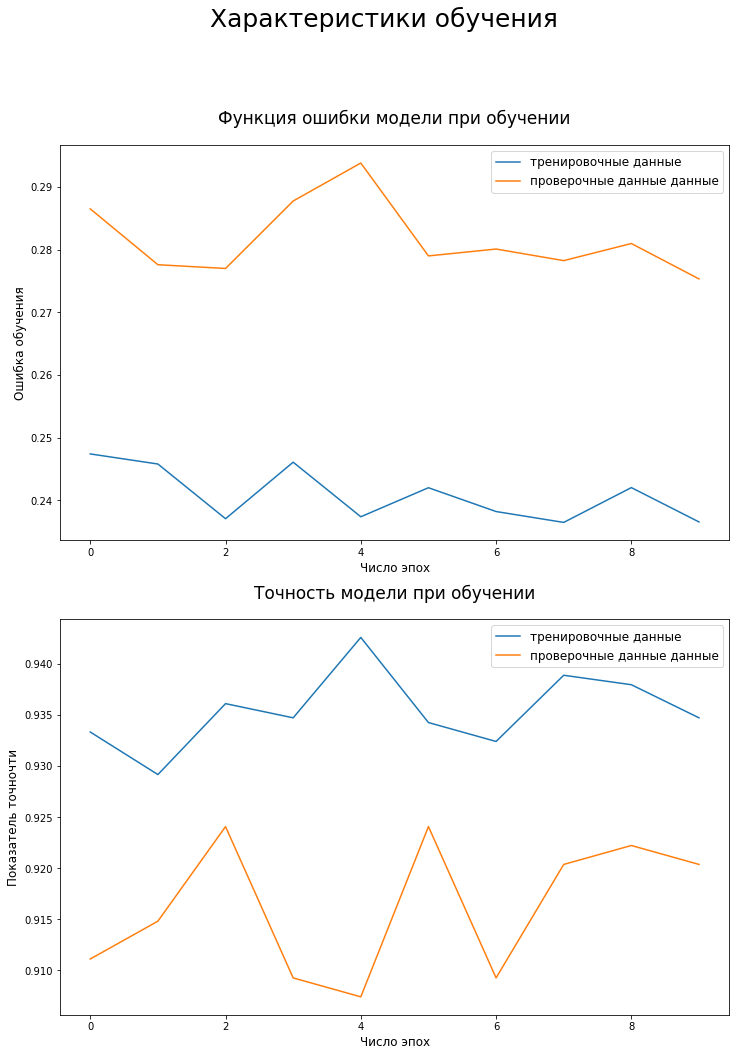

In [ ]:
plot_graphs(hist)

In [ ]:
model.save("audio_signal_processing.h5")

### **Проверка сети на тестовой выборке**

In [29]:
use_model = input("Необходимо ли использовать преобученную модель? (Да/Нет) - ")

Необходимо ли использовать преобученную модель? (Да/Нет) - Да


In [33]:
x_test = [x_base_test, x_mfcc_test,x_chroma_test]
test_acc = check_model(model,x_test,y_test, use_model)
print(f"Точность предсказания на тестовой выборке - {test_acc} %")

Путь к предобученной модели - /content/drive/MyDrive/Colab Notebooks/UAI/8.) Neural networks for audio processing/Neural networks/audio_signal_processing.h5
Точность предсказания на тестовой выборке - 96.33 %


### **HTML скрипт для записи аудио с микрофона**

In [34]:
AUDIO_HTML = """
<script>  // создаем тег <script>, сообщающий браузеру о том, что внутри находится исполняемый код JavaScript
var my_div = document.createElement("DIV");  // создаем новый элемент DIV(тег-контейнер для логического выделения блока документа)
var my_p = document.createElement("P");  // создаем новый элемент P(параграф для логической группировки текста)
var my_btn = document.createElement("BUTTON");  // создаем новый элемент(кнопку) BUTTON
var t = document.createTextNode("Press to start recording");  // создаем текстовое содержимое для кнопки

my_btn.appendChild(t);  // добавляем текстовое содержимое элементу BUTTON
my_div.appendChild(my_btn);  // кнопку с текстом BUTTON добавляем в блок DIV
document.body.appendChild(my_div);  // добавляем наш блок в элемент <body>("тело", для хранения содержимого веб-страницы)

var base64data = 0;  // будем использовать для аудиоданных метод кодирования информации в 64-разрядный код
var reader;  // создаем переменную для чтения файла
var recorder, gumStream; // объявляем переменные для записи данных/потока
var recordButton = my_btn; //  создаем переменную для кнопки записи аудио с микрофона

var handleSuccess = function(stream) {  // объявляем функцию для работы с потоками данных
  gumStream = stream;  // создаем переменную для потока
  var options = {
    mimeType : 'audio/webm;codecs=opus' // в опциях задаем медиа тип с аудиоформатом и кодеками
  };            
  recorder = new MediaRecorder(stream); // создаем новый объект MediaRecorder, получающий медиапоток для записи.
  // MediaRecorder - интерфейс MediaStream Recording API представляющий функциональность для простой записи медиа. Создается..
  // ..с использованием MediaRecorder() конструктора.
  recorder.ondataavailable = function(e) {  // вызываем обработчик dataavailable события, запускаемое по окончанию записи          
    var url = URL.createObjectURL(e.data); // этим методом создаем DOMString(UTF-16 String), содержащий URL с указанием на объект e.data
    var preview = document.createElement('audio'); // создаем элемент-тег аудио
    preview.controls = true; // активизируем элементы управления
    preview.src = url; // берем в кач-ве исходных данных файл, содержащийся в записанной ранее URL
    document.body.appendChild(preview); //добавляем элемент аудио в <body>("тело", для хранения содержимого веб-страницы)

    reader = new FileReader();  // создаем объект класса FileReader для чтения разных источников данных
    reader.readAsDataURL(e.data);  // читаем содержимое указанного файла
    reader.onloadend = function() {  // обработчик события, запускаемого после передачи данных
      base64data = reader.result; // записываем прочитанное содержимое в base64data
    }
  };
  recorder.start();  // начало записи медиа
  };

recordButton.innerText = "Идёт запись... нажмите для остановки"; // такой текст будет на кнопке BUTTON во время записи аудио

// запрос разрешения пользователя на доступ к устройству захвата аудио(микрофон), указываем True
navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {  // функция опишет действия по завершению записи (после клика мышкой по кнопке "Recording... press to stop")
  if (recorder && recorder.state == "recording") {  // если рекордер находится в процессе записи 
      recorder.stop();  // рекордер прерывается
      gumStream.getAudioTracks()[0].stop();  // отключается запись и доступ к микрофону
      recordButton.innerText = "Saving the recording... pls wait!" // эта надпись(сохранение записи) отобразится на кнопке BUTTON 
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {  // создаем функцию с задержкой вызова
  return new Promise(resolve => setTimeout(resolve, ms));  
  // new Promise - конструкция для отложенных вычислений
  // setTimeout позволяет вызвать функцию один раз через определённый интервал времени
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{  // при нажатии левой кнопкой мыши на кнопку "Recording... press to stop"
toggleRecording()  // вызывается функция завершения аудиозаписи

sleep(2000).then(() => {  // и после задержки 2000мс(2 сек)
  resolve(base64data.toString())  // полученные данные из формата base64 преобразовываем в строку

});

}
});
      
</script>
"""

### **Распознавание цифры по записи с микрофона**

In [53]:
if (use_model == "Да"):
  path_model = input("Путь к предобученной модели - ")
  model = models.load_model(filepath = path_model)

Путь к предобученной модели - /content/drive/MyDrive/Colab Notebooks/UAI/8.) Neural networks for audio processing/Neural networks/audio_signal_processing.h5


In [93]:
max_chroma = x_chroma.shape[2] # максимальная длина вектора в матрице x_chroma
max_mfcc = x_mfcc.shape[2] # максимальная длина вектора в матрице x_mfcc

In [103]:
recognition_number(model, AUDIO_HTML, max_chroma, max_mfcc)

Вы произнесли цифру - 6


## **5.) Выводы по проделанной работе**



> #### 1.   При формировании массива данных mfcc и chroma мы получаем различную длину последовательности данных в зависимости от длины аудиозаписи, для приведения всех записей к одной длине необходимо использовать pad_sequences.
> #### 2.   В данной работе я применил архитектуру, реализующую функциональное API. Каждый вход обработывал различные данные. Наборы mfcc и chroma обрабатывались при помощи двумерных свёрток, что позволило достичь точности 95.67 % на тестовой выборке.
> #### 3.   Суммарное время обучения модели составило 2.5 часа, что весьма немало.
> #### 4.   Уменьшение размера batch_size позволило быстрее добиться высокой точности. Снижение шага обучения на последнем этапе не помогло значительно повысить точность модели.
> #### 5.   При использовании MaxPooling2D нужно быть аккуратнее с размером получаемого тензера
> #### 6.   Во время тестирования распознавания микрофонной записи качество работы сети было не очень высокого уровня. Это связано с тем, что в выборке, на которой проходило обучение, не было моих записей. Проще всего алгоритму было распознать цифру 6.



